# Incarceration Rates Time Series Analysis
Author: Lorena Robles
----

## IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## Preparing the UN Incarceration Rates dataset for modeling

In [2]:
incarceration_rates = pd.read_csv('../../Datasets/Processed_Data/UN_Incarceration_Rates_Modeling.csv')

In [3]:
# Narrowing down the dataset to only the metrics needed for modeling
incarceration_rates = incarceration_rates[incarceration_rates['Unit of measurement'] == 'Rate per 100,000 population']
incarceration_rates = incarceration_rates[incarceration_rates['Age'] == 'Total']
incarceration_rates = incarceration_rates[incarceration_rates['Sex'] == 'Total']
incarceration_rates = incarceration_rates[incarceration_rates['Indicator'] == 'Persons held']
incarceration_rates = incarceration_rates[incarceration_rates['Dimension'] == 'Total']


In [4]:
# Dropping the last of unnecessary columns
incarceration_rates.drop(columns=['Age', 'Sex', 'Dimension', 'Indicator','Category','Unit of measurement'],inplace=True)

# Renaming the VALUE Column
incarceration_rates.rename(columns= {'VALUE':'Incarceration_Rate_Per_100_000'},inplace=True)

In [5]:
# Setting the Year as a datetime variable
incarceration_rates['Year'] = pd.to_datetime(incarceration_rates['Year'], format='%Y')

In [6]:
incarceration_rates.dtypes

Country                                   object
Year                              datetime64[ns]
Incarceration_Rate_Per_100_000           float64
dtype: object

In [7]:
# Setting the Year as index
incarceration_rates.set_index('Year', inplace=True)
incarceration_rates.head()

,Country,Incarceration_Rate_Per_100_000
Year,,
2000-01-01,Bangladesh,48.507923
2000-01-01,Nicaragua,127.634511
2001-01-01,Egypt,77.671504
2003-01-01,Angola,33.148789
2003-01-01,Albania,82.800112


### Separating our Country of interest into their own data frames

In [8]:
brazil = incarceration_rates[incarceration_rates['Country']== 'Brazil']
el_salvador =  incarceration_rates[incarceration_rates['Country']== 'El Salvador']
honduras =  incarceration_rates[incarceration_rates['Country']== 'Honduras']
mexico =  incarceration_rates[incarceration_rates['Country']== 'Mexico']
usa =  incarceration_rates[incarceration_rates['Country']== 'USA']

## Brazil ARIMA Model

In [9]:
brazil.sort_index(inplace=True)
brazil.tail()

,Country,Incarceration_Rate_Per_100_000
Year,,
2017-01-01,Brazil,346.359147
2018-01-01,Brazil,354.064836
2019-01-01,Brazil,356.626564
2020-01-01,Brazil,380.732211
2021-01-01,Brazil,389.893028


In [10]:
# Create first_diff_ridership and second_diff_ridership
brazil['First_Diff'] = brazil['Incarceration_Rate_Per_100_000'].diff()
brazil['Second_Diff'] = brazil['Incarceration_Rate_Per_100_000'].diff().diff()
brazil['Third_Diff'] = brazil['Incarceration_Rate_Per_100_000'].diff().diff().diff()  

C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\3270876084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brazil['First_Diff'] = brazil['Incarceration_Rate_Per_100_000'].diff()
C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\3270876084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brazil['Second_Diff'] = brazil['Incarceration_Rate_Per_100_000'].diff().diff()
C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\3270876084.py:4: SettingWithCopyWarning: 
A value is trying to be set on a

In [11]:
# Testing stationairty
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value']) # function from Summit's 3.03 Lesson, written by Joseph Nelson
    return dfoutput

interpret_dftest((adfuller(brazil['Incarceration_Rate_Per_100_000'])))

Test Statistic    0.27711
p-value           0.97627
dtype: float64

In [12]:
interpret_dftest((adfuller(brazil['First_Diff'].dropna())))

Test Statistic   -5.251799
p-value           0.000007
dtype: float64

In [13]:
interpret_dftest((adfuller(brazil['Second_Diff'].dropna())))

Test Statistic   -2.117446
p-value           0.237558
dtype: float64

In [14]:
interpret_dftest((adfuller(brazil['Third_Diff'].dropna())))

Test Statistic   -4.678545
p-value           0.000092
dtype: float64

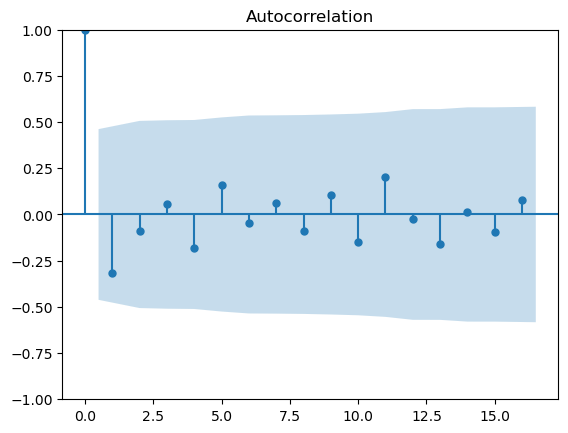

In [15]:
plot_acf(brazil['First_Diff'].dropna(), lags = 16);

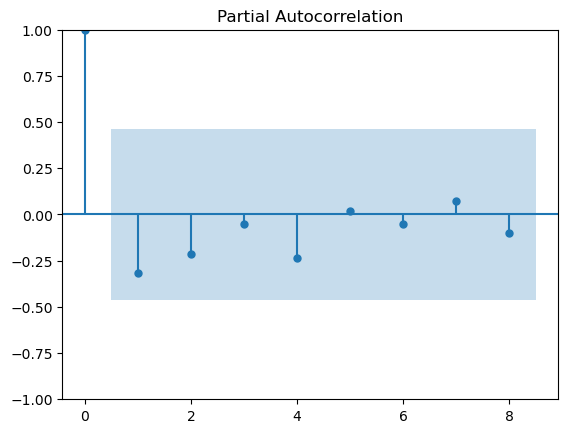

In [16]:
plot_pacf(brazil['First_Diff'].dropna(), lags = 8);

In [17]:
# Create train-test split.
train, test = train_test_split(brazil['Incarceration_Rate_Per_100_000'],
                                                    test_size = 0.15,
                                                    shuffle = False) 

In [18]:
train

Year
2003-01-01    156.047816
2004-01-01    182.088718
2005-01-01    193.472783
2006-01-01    212.495790
2007-01-01    221.507083
2008-01-01    234.189845
2009-01-01    252.667178
2010-01-01    261.749356
2011-01-01    269.750075
2012-01-01    285.190789
2013-01-01    300.516900
2014-01-01    298.698537
2015-01-01    340.476686
2016-01-01    349.087051
2017-01-01    346.359147
2018-01-01    354.064836
Name: Incarceration_Rate_Per_100_000, dtype: float64

In [19]:
# Instantiate model.

model = ARIMA(endog=train, 
             order = (0, 1, 0)) # order = (p, d, q)


c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [20]:
brazil_arima = model.fit()

In [21]:
brazil_predictions = brazil_arima.predict(start=datetime(2003,1,1), end=datetime(2025,1,1))

In [22]:
brazil_predictions

2003-01-01      0.000000
2004-01-01    156.047816
2005-01-01    182.088718
2006-01-01    193.472783
2007-01-01    212.495790
2008-01-01    221.507083
2009-01-01    234.189845
2010-01-01    252.667178
2011-01-01    261.749356
2012-01-01    269.750075
2013-01-01    285.190789
2014-01-01    300.516900
2015-01-01    298.698537
2016-01-01    340.476686
2017-01-01    349.087051
2018-01-01    346.359147
2019-01-01    354.064836
2020-01-01    354.064836
2021-01-01    354.064836
2022-01-01    354.064836
2023-01-01    354.064836
2024-01-01    354.064836
2025-01-01    354.064836
Freq: AS-JAN, Name: predicted_mean, dtype: float64

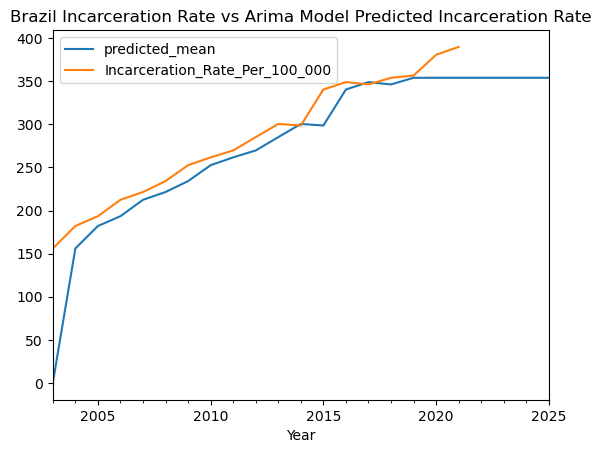

In [23]:
brazil_predictions.plot()
brazil['Incarceration_Rate_Per_100_000'].plot()
plt.title('Brazil Incarceration Rate vs Arima Model Predicted Incarceration Rate')
plt.legend()
plt.savefig('../../Images/Brazil_Incarceration_Rate_Predictions');

## El Salvador ARIMA Model

In [24]:
el_salvador.sort_index(inplace=True)
el_salvador.tail()

,Country,Incarceration_Rate_Per_100_000
Year,,
2015-01-01,El Salvador,533.744948
2016-01-01,El Salvador,589.135926
2017-01-01,El Salvador,633.815060
2018-01-01,El Salvador,631.609891
2019-01-01,El Salvador,636.299669


In [25]:
# Create first_diff_ridership and second_diff_ridership
el_salvador['First_Diff'] = el_salvador['Incarceration_Rate_Per_100_000'].diff()
el_salvador['Second_Diff'] = el_salvador['Incarceration_Rate_Per_100_000'].diff().diff()
el_salvador['Third_Diff'] = el_salvador['Incarceration_Rate_Per_100_000'].diff().diff().diff()
el_salvador['Fourth_Diff'] = el_salvador['Incarceration_Rate_Per_100_000'].diff().diff().diff().diff() 
el_salvador['Fifth_Diff'] = el_salvador['Incarceration_Rate_Per_100_000'].diff().diff().diff().diff().diff()   

C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\3939596298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  el_salvador['First_Diff'] = el_salvador['Incarceration_Rate_Per_100_000'].diff()
C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\3939596298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  el_salvador['Second_Diff'] = el_salvador['Incarceration_Rate_Per_100_000'].diff().diff()
C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\3939596298.py:4: SettingWithCopyWarning: 
A value is t

In [26]:
interpret_dftest((adfuller(el_salvador['Incarceration_Rate_Per_100_000'])))

Test Statistic   -1.458550
p-value           0.553907
dtype: float64

In [27]:
interpret_dftest((adfuller(el_salvador['First_Diff'].dropna())))

Test Statistic   -2.697338
p-value           0.074500
dtype: float64

In [28]:
interpret_dftest((adfuller(el_salvador['Second_Diff'].dropna())))

Test Statistic   -2.056317
p-value           0.262439
dtype: float64

In [29]:
interpret_dftest((adfuller(el_salvador['Third_Diff'].dropna())))

Test Statistic   -2.615064
p-value           0.089924
dtype: float64

In [30]:
interpret_dftest((adfuller(el_salvador['Fourth_Diff'].dropna())))

Test Statistic   -7.565124e+00
p-value           2.939542e-11
dtype: float64

In [31]:
interpret_dftest((adfuller(el_salvador['Fifth_Diff'].dropna())))

Test Statistic   -8.547145e+00
p-value           9.435965e-14
dtype: float64

In [32]:
# Create train-test split.
train, test = train_test_split(el_salvador['Incarceration_Rate_Per_100_000'],
                                                    test_size = 0.15,
                                                    shuffle = False) 
train

Year
2004-01-01    200.027984
2005-01-01    213.669941
2006-01-01    253.180248
2007-01-01    305.618789
2008-01-01    336.761150
2009-01-01    387.953909
2010-01-01    428.751261
2011-01-01    413.321812
2012-01-01    460.666591
2013-01-01    434.037370
2014-01-01    478.200713
2015-01-01    533.744948
2016-01-01    589.135926
Name: Incarceration_Rate_Per_100_000, dtype: float64

In [33]:

model_2 = ARIMA(endog=train, 
             order = (0, 1, 0)) # order = (p, d, q)

el_salvador_arima = model_2.fit()

el_salvador_predictions = el_salvador_arima.predict(start=datetime(2005,1,1), end=datetime(2025,1,1))

c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


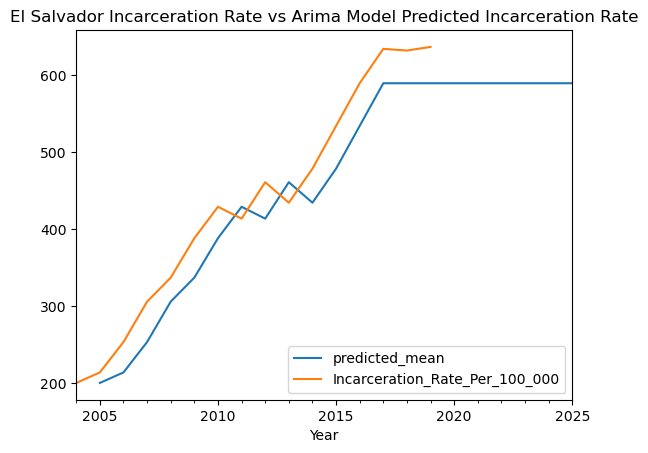

In [34]:
el_salvador_predictions.plot()
el_salvador['Incarceration_Rate_Per_100_000'].plot()
plt.title('El Salvador Incarceration Rate vs Arima Model Predicted Incarceration Rate')
plt.legend()
plt.savefig('../../Images/El_Salvador_Incarceration_Rate_Predictions');

## Hoduras ARIMA Model

In [35]:
honduras.sort_index(inplace=True)
honduras.tail()

,Country,Incarceration_Rate_Per_100_000
Year,,
2017-01-01,Honduras,200.844680
2018-01-01,Honduras,211.664633
2019-01-01,Honduras,217.144004
2020-01-01,Honduras,214.468566
2021-01-01,Honduras,196.432393


In [36]:
honduras['First_Diff'] = honduras['Incarceration_Rate_Per_100_000'].diff()
honduras['Second_Diff'] = honduras['Incarceration_Rate_Per_100_000'].diff().diff()
honduras['Third_Diff'] = honduras['Incarceration_Rate_Per_100_000'].diff().diff().diff()
honduras['Fourth_Diff'] = honduras['Incarceration_Rate_Per_100_000'].diff().diff().diff().diff() 
honduras['Fifth_Diff'] = honduras['Incarceration_Rate_Per_100_000'].diff().diff().diff().diff().diff()   



C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\668033468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  honduras['First_Diff'] = honduras['Incarceration_Rate_Per_100_000'].diff()
C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\668033468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  honduras['Second_Diff'] = honduras['Incarceration_Rate_Per_100_000'].diff().diff()
C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\668033468.py:3: SettingWithCopyWarning: 
A value is trying to be set

In [37]:
interpret_dftest((adfuller(honduras['Incarceration_Rate_Per_100_000'])))

Test Statistic   -39.072247
p-value            0.000000
dtype: float64

In [38]:
interpret_dftest((adfuller(honduras['First_Diff'].dropna())))

Test Statistic   -1.691005
p-value           0.435753
dtype: float64

In [39]:
interpret_dftest((adfuller(honduras['Second_Diff'].dropna())))

Test Statistic    1.940972
p-value           0.998591
dtype: float64

In [40]:
interpret_dftest((adfuller(honduras['Third_Diff'].dropna())))

Test Statistic   -3.966469
p-value           0.001597
dtype: float64

In [41]:

interpret_dftest((adfuller(honduras['Fourth_Diff'].dropna())))


Test Statistic   -29.583104
p-value            0.000000
dtype: float64

In [42]:
interpret_dftest((adfuller(honduras['Fifth_Diff'].dropna())))

Test Statistic   -1.015366e+01
p-value           7.831482e-18
dtype: float64

In [43]:
train, test = train_test_split(honduras['Incarceration_Rate_Per_100_000'],
                                                    test_size = 0.15,
                                                    shuffle = False) 
train


Year
2004-01-01    148.048194
2005-01-01    153.200170
2006-01-01    144.321644
2008-01-01    140.586442
2010-01-01    139.274571
2011-01-01    142.418018
2012-01-01    137.562510
2013-01-01    147.132069
2014-01-01    163.039552
2015-01-01    173.844644
2016-01-01    184.910416
2017-01-01    200.844680
2018-01-01    211.664633
Name: Incarceration_Rate_Per_100_000, dtype: float64

In [44]:
test

Year
2019-01-01    217.144004
2020-01-01    214.468566
2021-01-01    196.432393
Name: Incarceration_Rate_Per_100_000, dtype: float64

In [45]:
model_3 = ARIMA(endog=train, 
             order = (0, 1, 0)) # order = (p, d, q)

c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [52]:
honduras_arima = model_3.fit()

honduras_predictions = honduras_arima.predict(start=datetime(2005,1,1), end=datetime(2025,1,1))

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [53]:
honduras_predictions.plot()
honduras['Incarceration_Rate_Per_100_000'].plot()
plt.title('Honduras Incarceration Rate vs Arima Model Predicted Incarceration Rate')
plt.legend()
plt.savefig('../../Images/Honduras_Incarceration_Rate_Predictions');

NameError: name 'honduras_predictions' is not defined

## Mexico ARIMA Model

In [54]:
mexico.sort_index(inplace=True)
mexico.tail()

,Country,Incarceration_Rate_Per_100_000
Year,,
2017-01-01,Mexico,164.363579
2018-01-01,Mexico,158.306497
2019-01-01,Mexico,158.935529
2020-01-01,Mexico,167.584799
2021-01-01,Mexico,173.962164


In [55]:
mexico['First_Diff'] = mexico['Incarceration_Rate_Per_100_000'].diff()
mexico['Second_Diff'] = mexico['Incarceration_Rate_Per_100_000'].diff().diff()
mexico['Third_Diff'] = mexico['Incarceration_Rate_Per_100_000'].diff().diff().diff()
mexico['Fourth_Diff'] = mexico['Incarceration_Rate_Per_100_000'].diff().diff().diff().diff() 
mexico['Fifth_Diff'] = mexico['Incarceration_Rate_Per_100_000'].diff().diff().diff().diff().diff()   

C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\3334693585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mexico['First_Diff'] = mexico['Incarceration_Rate_Per_100_000'].diff()
C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\3334693585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mexico['Second_Diff'] = mexico['Incarceration_Rate_Per_100_000'].diff().diff()
C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\3334693585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a

In [56]:
interpret_dftest((adfuller(mexico['Incarceration_Rate_Per_100_000'])))

Test Statistic    2.776339
p-value           1.000000
dtype: float64

In [57]:
interpret_dftest((adfuller(mexico['First_Diff'].dropna())))

Test Statistic   -1.501080
p-value           0.532977
dtype: float64

In [58]:
interpret_dftest((adfuller(mexico['Second_Diff'].dropna())))

Test Statistic   -5.009068
p-value           0.000021
dtype: float64

In [59]:
interpret_dftest((adfuller(mexico['Third_Diff'].dropna())))

Test Statistic   -4.076527
p-value           0.001059
dtype: float64

In [60]:
interpret_dftest((adfuller(mexico['Fourth_Diff'].dropna())))

Test Statistic   -2.422293
p-value           0.135543
dtype: float64

In [61]:
interpret_dftest((adfuller(mexico['Fifth_Diff'].dropna())))

Test Statistic   -1.134560
p-value           0.701095
dtype: float64

In [62]:
train, test = train_test_split(mexico['Incarceration_Rate_Per_100_000'],
                                                    test_size = 0.15,
                                                    shuffle = False) 
train

Year
2003-01-01    181.203938
2004-01-01    189.114880
2005-01-01    197.522057
2006-01-01    197.693279
2007-01-01    198.223552
2008-01-01    200.351028
2009-01-01    168.045890
2010-01-01    167.074548
2011-01-01    187.259833
2012-01-01    179.064725
2013-01-01    186.181025
2014-01-01    192.008165
2015-01-01    184.302280
2016-01-01    156.497875
2017-01-01    164.363579
2018-01-01    158.306497
Name: Incarceration_Rate_Per_100_000, dtype: float64

In [63]:
model_4 = ARIMA(endog=train, 
             order = (0, 1, 0)) # order = (p, d, q)

mexico_arima = model_4.fit()

mexico_predictions = mexico_arima.predict(start=datetime(2005,1,1), end=datetime(2025,1,1))


c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


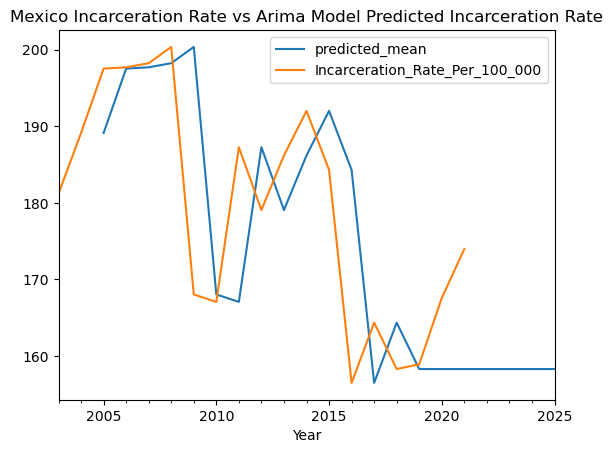

In [64]:
mexico_predictions.plot()
mexico['Incarceration_Rate_Per_100_000'].plot()
plt.title('Mexico Incarceration Rate vs Arima Model Predicted Incarceration Rate')
plt.legend()
plt.savefig('../../Images/Mexico_Incarceration_Rate_Predictions');

## USA ARIMA Model

In [65]:
usa.sort_index(inplace=True)
usa.tail()

,Country,Incarceration_Rate_Per_100_000
Year,,
2017-01-01,USA,653.019183
2018-01-01,USA,639.218330
2019-01-01,USA,620.244689
2020-01-01,USA,498.359831
2021-01-01,USA,524.425062


In [66]:
usa['First_Diff'] = usa['Incarceration_Rate_Per_100_000'].diff()
usa['Second_Diff'] = usa['Incarceration_Rate_Per_100_000'].diff().diff()
usa['Third_Diff'] = usa['Incarceration_Rate_Per_100_000'].diff().diff().diff()
usa['Fourth_Diff'] = usa['Incarceration_Rate_Per_100_000'].diff().diff().diff().diff() 
usa['Fifth_Diff'] = usa['Incarceration_Rate_Per_100_000'].diff().diff().diff().diff().diff()   

C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\1913774518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa['First_Diff'] = usa['Incarceration_Rate_Per_100_000'].diff()
C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\1913774518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa['Second_Diff'] = usa['Incarceration_Rate_Per_100_000'].diff().diff()
C:\Users\Alex_Compu\AppData\Local\Temp\ipykernel_1280\1913774518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [67]:
interpret_dftest((adfuller(usa['Incarceration_Rate_Per_100_000'])))

Test Statistic    43.259902
p-value            1.000000
dtype: float64

In [68]:
interpret_dftest((adfuller(usa['First_Diff'].dropna())))

Test Statistic    4.602071
p-value           1.000000
dtype: float64

In [69]:
interpret_dftest((adfuller(usa['Second_Diff'].dropna())))

Test Statistic   -6.600863e+00
p-value           6.741418e-09
dtype: float64

In [70]:
interpret_dftest((adfuller(usa['Third_Diff'].dropna())))

Test Statistic   -1.149478e+01
p-value           4.642671e-21
dtype: float64

In [71]:
interpret_dftest((adfuller(usa['Fourth_Diff'].dropna())))

Test Statistic   -5.027644
p-value           0.000020
dtype: float64

In [72]:
interpret_dftest((adfuller(usa['Fifth_Diff'].dropna())))

Test Statistic   -6.333700e+00
p-value           2.864831e-08
dtype: float64

In [73]:
train, test = train_test_split(usa['Incarceration_Rate_Per_100_000'],
                                                    test_size = 0.15,
                                                    shuffle = False) 
train


Year
2003-01-01    739.583431
2004-01-01    733.429328
2005-01-01    741.268093
2006-01-01    752.819576
2007-01-01    758.530165
2008-01-01    755.753506
2009-01-01    744.768351
2010-01-01    732.398986
2011-01-01    717.638696
2012-01-01    704.686781
2013-01-01    695.890049
2014-01-01    690.951965
2015-01-01    669.361660
2016-01-01    661.684756
2017-01-01    653.019183
2018-01-01    639.218330
Name: Incarceration_Rate_Per_100_000, dtype: float64

In [74]:
model_5 = ARIMA(endog=train, 
             order = (0, 4, 0)) # order = (p, d, q)

usa_arima = model_5.fit()

usa_predictions = usa_arima.predict(start=datetime(2007,1,1), end=datetime(2025,1,1))


c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Alex_Compu\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


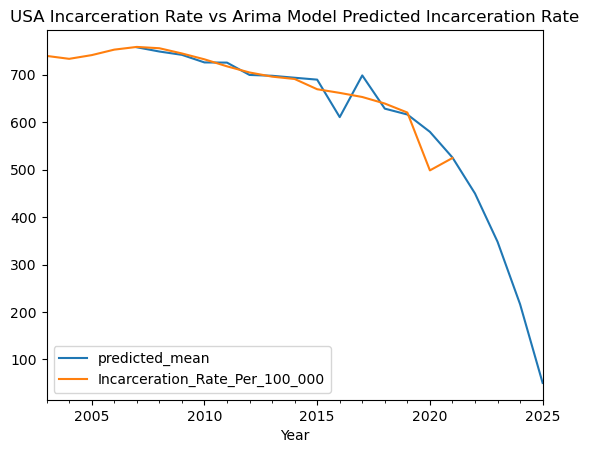

In [75]:
usa_predictions.plot()
usa['Incarceration_Rate_Per_100_000'].plot()
plt.title('USA Incarceration Rate vs Arima Model Predicted Incarceration Rate')
plt.legend()
plt.savefig('../../Images/USA_Incarceration_Rate_Predictions');

Summary

This was the beginning of a time series analysis I wanted to try for practice and, at this point it does not add value to our project analysis. This is also the reason why at this point I am not looking int the runtime error for model_3. 

In the future I want to use some of the indicators I found in the other datasets which were highly correlated to incarceration rate to include in a time Series analysis and compare the results. 